## Generating Supratidal forest extent (STF) for PNG
- NOTE: very experimental! not even sure if the outputs are correct
- loading all external data at the moment (WCF, DEM, GMW for mangroves - https://data.unep-wcmc.org/datasets/45)
- ideally needs an Intertidal Extent Model (ITEM) but dont have this for PNG

In [16]:
import numpy as np
import xarray as xr

import datacube
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.drivers.netcdf import write_dataset_to_netcdf

import warnings
warnings.filterwarnings('ignore')

dc = datacube.Datacube(app='Generating_WOfS')
from dea_tools.plotting import display_map


In [2]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True);

In [3]:
latitude = (-7.3, -7.4)
longitude = (144.4, 144.5)
display_map(longitude, latitude)

In [4]:
# load in DEM
# load DEM
dem = dc.load(
    product="copernicus_dem_30", 
    latitude=latitude,
    longitude=longitude,
    output_crs="EPSG:32755", 
    resolution=(-30, 30),
)
elevation = dem.elevation


In [32]:
# load WCF and GMW
WCF_path = '../data/WCF_test.tif'
GMW_path = '../data/GMW_S07E144_2020_v3_EPSG32755.tif'

In [33]:
# now cut out WCF and GMW to DEM
WCF = rio_slurp_xarray(WCF_path, gbox=elevation.geobox)
WCF.attrs['crs'] = 'EPSG:32755'

GMW = rio_slurp_xarray(GMW_path, gbox=elevation.geobox)
GMW.attrs['crs'] = 'EPSG:32755'


In [43]:
# WCF threshold
woody_cover = xr.where(WCF > 0.5, 1, 0).astype('int8')

# wrangle binary maps and create STF mask

# not mangrove == True
not_mangrove = (1 - GMW)
not_mangrove = not_mangrove == 1

# greater than 1m AHD and less than 10m AHD == True
elev_min = 1
elev_max = 20

lessthan10m = elevation <= elev_max
greaterthan1m = elevation >= elev_min
elev_threshold = lessthan10m & greaterthan1m

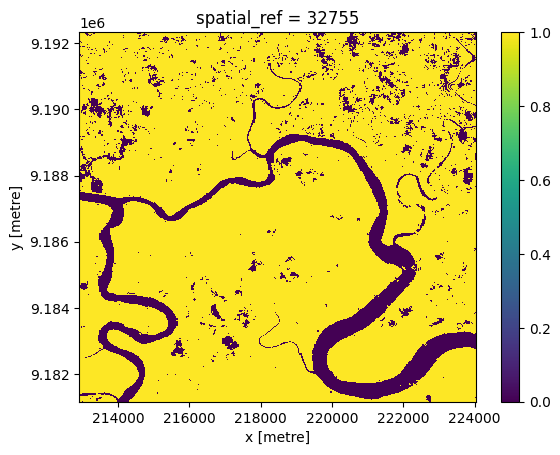

In [44]:
woody_cover.plot()

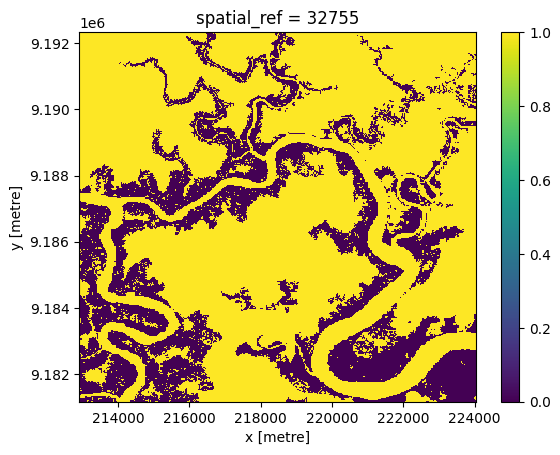

In [45]:
not_mangrove.plot()

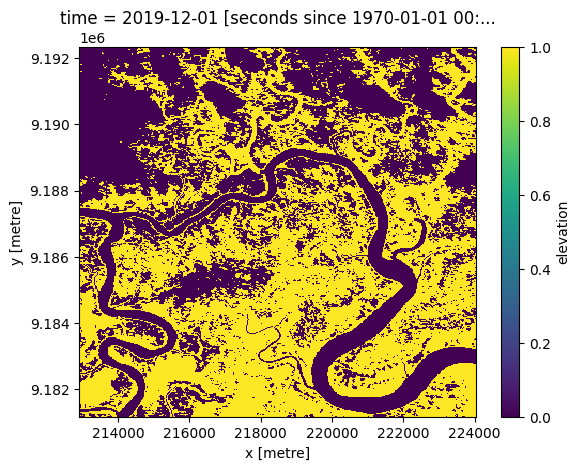

In [46]:
elev_threshold.plot()

In [47]:
STF = xr.where((woody_cover == False) + (not_mangrove == False) + (elev_threshold == False), 0, 1).astype('int8')

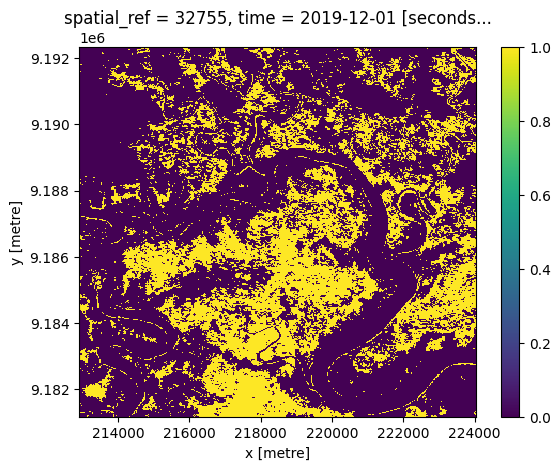

In [48]:
STF.plot()

In [52]:
# make to ds for .nc export
STF_ds = STF.to_dataset(name='STF')

# output as cog
write_cog(STF, '../data/STF_test.tif', overwrite=True)

# export out as .nc to allow load back in easily as xarray
write_dataset_to_netcdf(STF_ds, '../data/STF_test.nc')
